# Key Objectives are:


- Explore the data – be creative and pay attention to the details. You need to provide the marketing team a better understanding of the characteristic features of respondents;

- Propose and describe a customer segmentation based on customers behaviors;

- __Create a predictive model which allows the company to maximize the profit of the next marketing campaign.__

In [404]:
#Libraries
import numpy as np 
import pandas as pd
pd.set_option('display.max_columns', None) #shows all the dfs columns
import matplotlib.pyplot as plt
import seaborn as sns
import re

#Recomended: Control dpi
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [382]:
path = '/Users/mgermano/Documents/coding_test/ifood/project_model_cluster/output/dataset.csv'
df = pd.read_csv(path)
df.head(n=4)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,57
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,60
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0,49
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0,30


## Data Cleaning

First, let's start by cleaning the data and throwing away some columns that are not important

In [383]:
def clean(dataset):
    dataset = dataset.drop(['Year_Birth'], axis=1)
    dataset = dataset.drop(['ID'], axis=1)
    dataset = dataset.drop(['Z_CostContact'], axis=1)
    dataset = dataset.drop(['Z_Revenue'], axis=1)
    dataset = dataset.drop(['Dt_Customer'], axis=1)
    


    return dataset


df_model = clean(df)
df_model.head(n=4)

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,57
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,60
2,Graduation,Together,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,49
3,Graduation,Together,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,30


## Feature Engineering 

In this section, we will apply the knowledge we learned from the EDA. In the EDA we saw that the family size plays a role in the response. Let's create 2 features for small families with kids and small families with teenagers.

In [384]:
def family_size(dataset):
    ''' this function creates a new feature if the family is either alone  or has 1 kid/teen (True),
    else it returns false.  '''
    dataset['SmallFamily_kid'] = dataset['Kidhome'].apply(
        lambda x: 'True' if x <= 1 else 'False')
    dataset['SmallFamily_teen'] = dataset['Teenhome'].apply(
        lambda x: 'True' if x <= 1 else 'False')

    return dataset


df_model = family_size(df_model)

In [385]:
df_model['Education'].value_counts()

Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: Education, dtype: int64

In [386]:
def higher_education(dataset):
    ''' this function adds a new feature if it a person has higher_education (True) 
    or if the person doesn't have (False)'''
    dataset['has_HigherEd'] = dataset['Education'].apply(
        lambda x: 'True' if re.search(r'\bGraduation\b', x) or re.search(
            r'\bPhD\b', x) or re.search(r'\bMaster\b', x) else 'False')

    return dataset


df_model = higher_education(df_model)

In [387]:
def higher_income(dataset):
    ''' this function adds a new feature if it a person has higher_education (True) 
    or if the person doesn't have (False)'''
    dataset['HighIncome'] = dataset['Income'].apply(lambda x: 'True'
                                                    if x >= 60000 else 'False')

    return dataset


df_model = higher_income(df_model)

There are features that are categorical. Now we only need to convert these categorical features into numerical, so our model understands the input. We will apply a technique called "One hot encoding". One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

In [388]:
#convert from booleans to numeric
df_model[['SmallFamily_kid', 'SmallFamily_teen', 'has_HigherEd',
          'HighIncome']] = (df_model[[
              'HighIncome', 'SmallFamily_kid', 'SmallFamily_teen',
              'has_HigherEd'
          ]] == 'True').astype(int)
#apply One hot encoding
df_model = pd.get_dummies(df_model)
df_model.head(n=4)

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,SmallFamily_kid,SmallFamily_teen,has_HigherEd,HighIncome,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Absurd,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO
0,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,57,0,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0
1,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,60,0,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0
2,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,49,1,1,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0
3,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,30,0,1,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0


## Modeling

We will approach for this problem with machine learning classification models. Classification refers to a predictive modeling problem where a class label is predicted for a given example of input data. 

Since it wasn't given a test set, I will split our own dataset into train and test set. The fraction chosen for this model is 75/25.

In [515]:
train = df_model.sample(frac=0.75,
                        random_state=30)  #random state is a seed value

test = df_model.drop(train.index)
y_true = test['Response']
test = test.drop('Response', axis=1)

One of the problems on this dataset is that the data is imbalanced (more No's than yes). I tried using smote to balance it. However, the models overfitted, so I abandoned this approach. If you want to try it, just uncomment the last line 

In [516]:
from imblearn.over_sampling import RandomOverSampler

sm = SMOTE(random_state=27, n_jobs=-1)

X_train = train.drop('Response', axis=1)
y_train = train['Response']
X_train, y_train = sm.fit_sample(X_train, y_train)

#train = pd.concat([X_train,y_train], axis=1) #uncomment this line to try smote oversampling

In the EDA it was possible to verify that some features had high correlation (multicollinearity), so in the setup I will remove features with correlation above 0.9

In [517]:
from pycaret.classification import *

model_setup = setup(data=train,
                    target='Response',
                    remove_multicollinearity=True,
                    multicollinearity_threshold=0.9,
                    session_id=1,
                    silent=True)

 
Setup Succesfully Completed!


,Description,Value
0,session_id,1
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(1680, 40)"
4,Missing Values,False
5,Numeric Features,22
6,Categorical Features,17
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Let's start by comparing different model. I will set k-fold cross-validation with k=10 and calculate the accuracy, AUC, recall, precision, F1, and kappa.A cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample. The simple diagram below explain how it works.


<img src="https://ethen8181.github.io/machine-learning/model_selection/img/kfolds.png">


In [518]:
compare_models(fold=10, sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Linear Discriminant Analysis,0.8808,0.8648,0.4667,0.6625,0.5423,0.4767
1,CatBoost Classifier,0.8723,0.8647,0.3778,0.6533,0.4762,0.4093
2,Light Gradient Boosting Machine,0.8698,0.8611,0.4,0.6293,0.4827,0.413
3,Gradient Boosting Classifier,0.8732,0.8571,0.4,0.6513,0.4899,0.4225
4,Extreme Gradient Boosting,0.8638,0.8562,0.3278,0.6216,0.4238,0.3548
5,Extra Trees Classifier,0.8672,0.8304,0.2667,0.7012,0.3787,0.3207
6,Ada Boost Classifier,0.8681,0.8281,0.3944,0.6205,0.4779,0.4068
7,Random Forest Classifier,0.8544,0.7922,0.2167,0.5586,0.3052,0.2441
8,Logistic Regression,0.8511,0.7695,0.1833,0.5682,0.2659,0.2084
9,Naive Bayes,0.7915,0.7468,0.4944,0.3712,0.4212,0.2985


The Light Gradient Boosting Machine showed as the best model by the time I ran this notebook. Therefore, I will use this model. Let's tune this model first.

In [519]:
model_tuned = tune_model('lightgbm', fold=10, optimize='AUC', ensemble=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8475,0.8061,0.4444,0.5000,0.4706,0.3818
1,0.8475,0.8561,0.3333,0.5000,0.4000,0.3166
2,0.8898,0.8083,0.4444,0.7273,0.5517,0.4931
3,0.8390,0.8433,0.4444,0.4706,0.4571,0.3627
4,0.8983,0.8678,0.5000,0.7500,0.6000,0.5444
5,0.8547,0.9270,0.4444,0.5333,0.4848,0.4011
6,0.8547,0.8176,0.3333,0.5455,0.4138,0.3363
7,0.8376,0.8356,0.2778,0.4545,0.3448,0.2583
8,0.8889,0.9304,0.6111,0.6471,0.6286,0.5633
9,0.8889,0.8446,0.3889,0.7778,0.5185,0.4635


I tried to optimize the AUC score and we see that the AUC improves a bit from 0.851 to 0.8567 on average

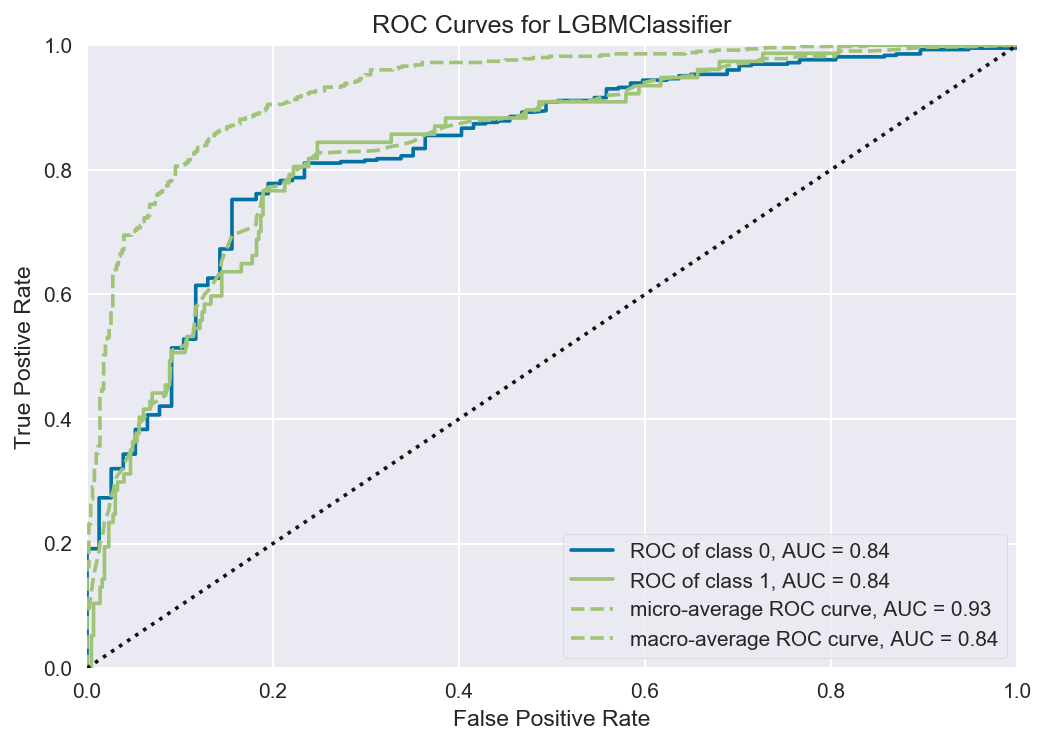

In [520]:
plot_model(model_tuned,plot = 'auc') 

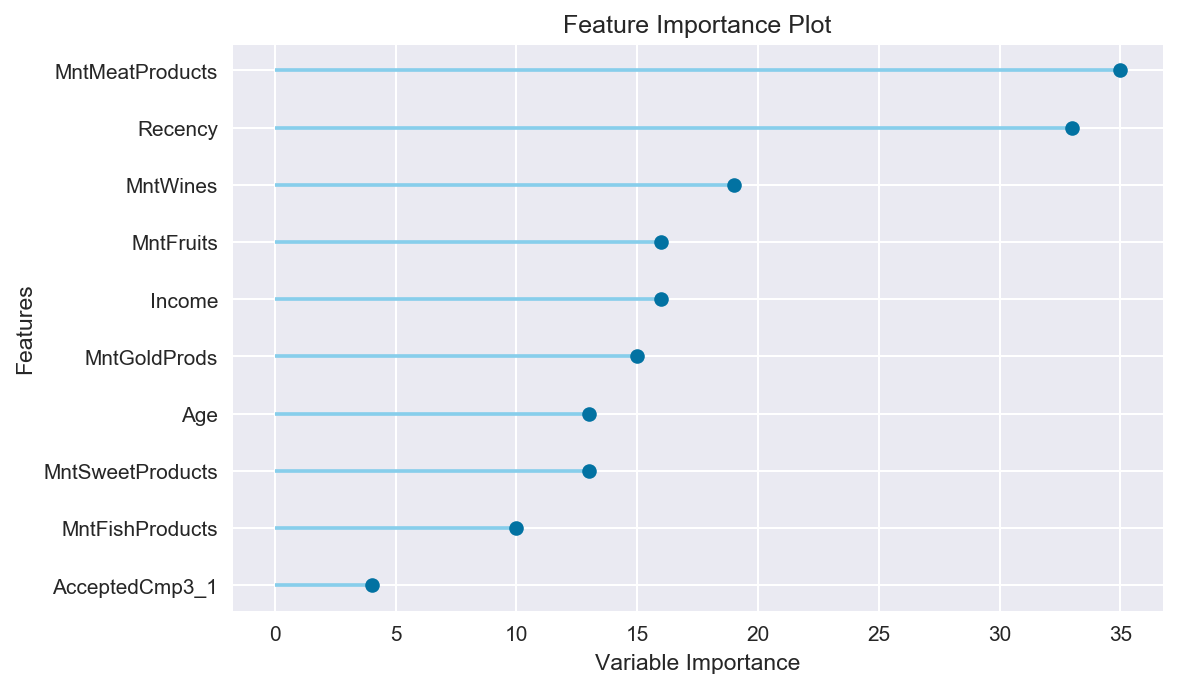

In [521]:
plot_model(model_tuned,plot = 'feature')

One interesting thing is that the model's feature importance. We see that ```Recency``` and ```MntMeatProducts``` has the biggest importance in the model prediction. This gives us some guidance on how to improve customer acquisition for the business. Furthermore, ```Income```, as expected, was an important variable for the model.

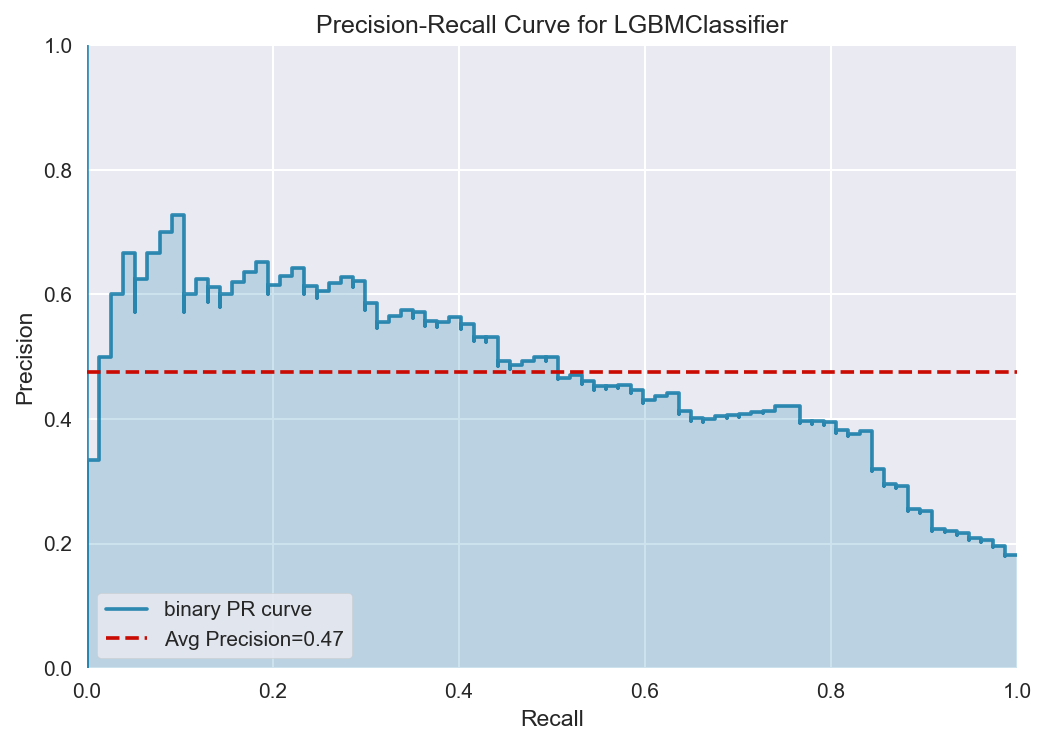

In [522]:
plot_model(model_tuned,plot = 'pr') 

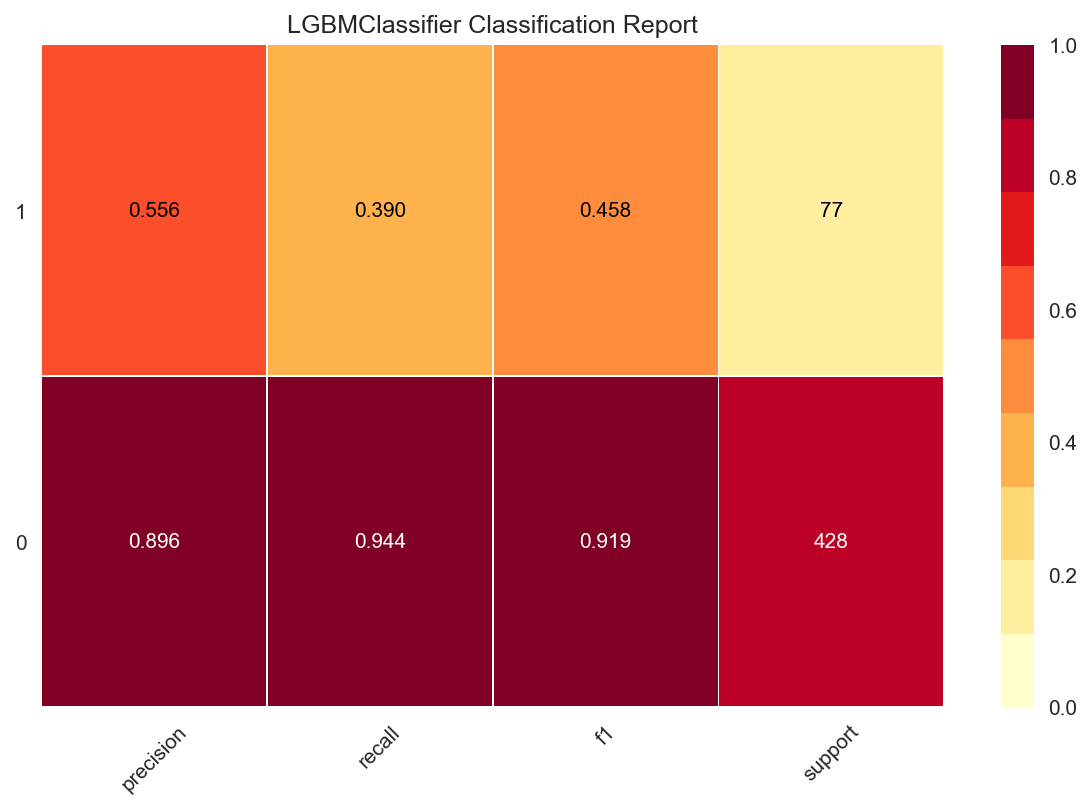

In [523]:
plot_model(model_tuned,plot = 'class_report') 

The figure above shows us that in general the metrics were better for when the customer's response was no (0). This could be related to the fact that our data is imbalanced. 

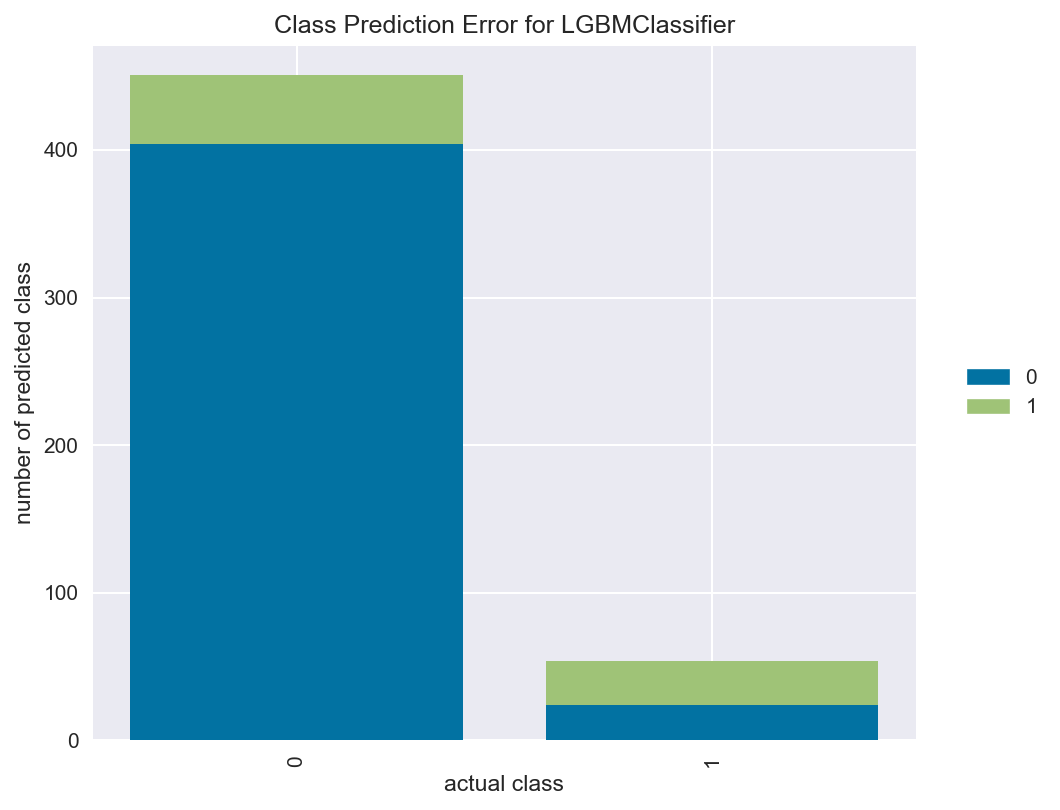

In [533]:
plot_model(model_tuned,plot = 'error') 

## Predictions and Results

In [525]:
#generate predictions on hold-out set using trained model
y_pred = predict_model(model_tuned, data=test)

In [526]:
from sklearn.metrics import roc_auc_score, recall_score, precision_score, accuracy_score, f1_score, cohen_kappa_score
sc = roc_auc_score(y_true, y_pred['Label'])
recall = recall_score(y_true, y_pred['Label'])
precision = precision_score(y_true, y_pred['Label'])
sca = accuracy_score(y_true, y_pred['Label'])
f1 = f1_score(y_true, y_pred['Label'])
kappa = cohen_kappa_score(y_true, y_pred['Label'])

fold_results = pd.DataFrame({
    'Accuracy': [sca],
    'AUC': [sc],
    'Recall': [recall],
    'Prec.': [precision],
    'F1': [f1],
    'Kappa': [kappa]
}).round(2)
fold_results

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9,0.71,0.44,0.72,0.55,0.5


### The Wrap Up 


The classification model allowed us to predict the customer's responses. A few remarks we can extract from this approach: 

- The model showed us that ```Recency``` and ```MntMeatProducts``` have a large impact in the model predictions, so in future marketing campaigns this should be considered as an important feature.
- As showed in the EDA and customer segmentation, the income is a very important feature.
- Our dataset is imbalanced, so there is a clear difference in the precision and recall scores. Depending on the final goal of the campaigns, this should be adjusted. 